In [54]:
import pandas as pd
import shap
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import IsolationForest
import joblib

In [28]:
customer_info = pd.read_csv("customer_info.csv")
merchant_info = pd.read_csv("merchant_info.csv")

In [29]:
customer_info = customer_info.dropna()

In [30]:
merchant_info = merchant_info.dropna()

In [31]:
customer_info.columns

Index(['CustomerID', 'AccountBalance', 'LastLogin', 'Name', 'Age', 'Address',
       'TransactionID', 'Amount', 'SuspiciousFlag'],
      dtype='object')

In [32]:
merchant_info.columns

Index(['MerchantID', 'MerchantName', 'Location', 'TransactionID', 'Category',
       'TransactionAmount', 'AnomalyScore', 'Timestamp'],
      dtype='object')

## Customer Info Modelling

In [33]:
customer_info.head(1)

,CustomerID,AccountBalance,LastLogin,Name,Age,Address,TransactionID,Amount,SuspiciousFlag
0,1001,9507.27206,2022-01-01,Customer 1001,54,Address 1001,787.0,33.670626,0


In [34]:
customer_info.shape

(1000, 9)

In [35]:
len(customer_info["CustomerID"].unique())

636

In [36]:
customer = customer_info[["TransactionID", "CustomerID", "AccountBalance", "LastLogin", "Name", "Age", "Amount", "Address"]]

In [37]:
customer['LastLogin'] = pd.to_datetime(customer['LastLogin'])
customer['Day'] = customer['LastLogin'].dt.day
customer['Month'] = customer['LastLogin'].dt.month
customer['Year'] = customer['LastLogin'].dt.year


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [38]:
customer

,TransactionID,CustomerID,AccountBalance,LastLogin,Name,Age,Amount,Address,Day,Month,Year
0,787.0,1001,9507.272060,2022-01-01,Customer 1001,54,33.670626,Address 1001,1,1,2022
2,641.0,1003,1715.321989,2022-01-03,Customer 1003,40,30.980239,Address 1003,3,1,2022
3,450.0,1004,3101.509134,2022-01-04,Customer 1004,30,11.167088,Address 1004,4,1,2022
4,921.0,1004,3101.509134,2022-01-04,Customer 1004,30,45.849784,Address 1004,4,1,2022
5,599.0,1005,5405.766914,2022-01-05,Customer 1005,46,81.808651,Address 1005,5,1,2022
...,...,...,...,...,...,...,...,...,...,...,...
1359,236.0,1999,7376.854107,2024-09-25,Customer 1999,57,69.825072,Address 1999,25,9,2024
1360,805.0,1999,7376.854107,2024-09-25,Customer 1999,57,34.780068,Address 1999,25,9,2024
1361,44.0,2000,4853.024380,2024-09-26,Customer 2000,42,86.971920,Address 2000,26,9,2024
1362,779.0,2000,4853.024380,2024-09-26,Customer 2000,42,86.049092,Address 2000,26,9,2024


In [39]:
label_encoder = LabelEncoder()
customer['Name'] = label_encoder.fit_transform(customer['Name'])
customer['Address'] = label_encoder.fit_transform(customer['Address'])

In [40]:
customer

,TransactionID,CustomerID,AccountBalance,LastLogin,Name,Age,Amount,Address,Day,Month,Year
0,787.0,1001,9507.272060,2022-01-01,0,54,33.670626,0,1,1,2022
2,641.0,1003,1715.321989,2022-01-03,1,40,30.980239,1,3,1,2022
3,450.0,1004,3101.509134,2022-01-04,2,30,11.167088,2,4,1,2022
4,921.0,1004,3101.509134,2022-01-04,2,30,45.849784,2,4,1,2022
5,599.0,1005,5405.766914,2022-01-05,3,46,81.808651,3,5,1,2022
...,...,...,...,...,...,...,...,...,...,...,...
1359,236.0,1999,7376.854107,2024-09-25,634,57,69.825072,634,25,9,2024
1360,805.0,1999,7376.854107,2024-09-25,634,57,34.780068,634,25,9,2024
1361,44.0,2000,4853.024380,2024-09-26,635,42,86.971920,635,26,9,2024
1362,779.0,2000,4853.024380,2024-09-26,635,42,86.049092,635,26,9,2024


In [41]:
columns_to_normalize = ['AccountBalance', 'Age', 'Amount', 'Day', 'Month', 'Year']
scaler = StandardScaler()
customer[columns_to_normalize] = scaler.fit_transform(customer[columns_to_normalize])

In [42]:
encoded_df = customer[["TransactionID", "CustomerID", "AccountBalance", "Name", "Age", "Amount", "Address", "Day", "Month", "Year"]]

In [43]:
model = IsolationForest(n_estimators=100, max_samples=256, contamination=0.1)

In [44]:
model.fit(encoded_df)

IsolationForest(contamination=0.1, max_samples=256)

In [45]:
anomalies = model.predict(encoded_df)

In [46]:
customer_info['anomaly'] = anomalies
customer['anomaly'] = anomalies

In [47]:
customer_info

,CustomerID,AccountBalance,LastLogin,Name,Age,Address,TransactionID,Amount,SuspiciousFlag,anomaly
0,1001,9507.272060,2022-01-01,Customer 1001,54,Address 1001,787.0,33.670626,0,-1
2,1003,1715.321989,2022-01-03,Customer 1003,40,Address 1003,641.0,30.980239,0,-1
3,1004,3101.509134,2022-01-04,Customer 1004,30,Address 1004,450.0,11.167088,0,-1
4,1004,3101.509134,2022-01-04,Customer 1004,30,Address 1004,921.0,45.849784,0,-1
5,1005,5405.766914,2022-01-05,Customer 1005,46,Address 1005,599.0,81.808651,0,-1
...,...,...,...,...,...,...,...,...,...,...
1359,1999,7376.854107,2024-09-25,Customer 1999,57,Address 1999,236.0,69.825072,0,-1
1360,1999,7376.854107,2024-09-25,Customer 1999,57,Address 1999,805.0,34.780068,0,-1
1361,2000,4853.024380,2024-09-26,Customer 2000,42,Address 2000,44.0,86.971920,0,-1
1362,2000,4853.024380,2024-09-26,Customer 2000,42,Address 2000,779.0,86.049092,0,-1


In [48]:
shap.initjs()

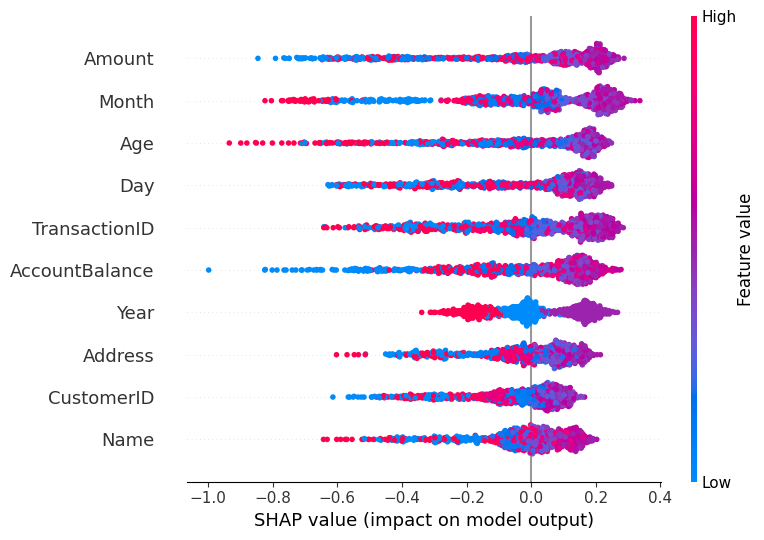

In [49]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(encoded_df)
shap.summary_plot(shap_values, encoded_df)

In [52]:
model_dict = {
    "label_encoder": label_encoder,
    "scaler": scaler,
    "model": model
}

In [60]:
with open('model_dict.joblib', 'wb') as scaler_file:
    joblib.dump(model_dict, scaler_file)

## Predicting with the model artifact

In [84]:
with open('model_dict.joblib', 'rb') as model_file:
    loaded_model = joblib.load(model_file)

In [85]:
loaded_model

{'label_encoder': LabelEncoder(),
 'scaler': StandardScaler(),
 'model': IsolationForest(contamination=0.1, max_samples=256)}

In [106]:
test = customer_info[["TransactionID", "CustomerID", "AccountBalance", "LastLogin", "Name", "Age", "Amount", "Address"]].loc[[4]]

In [107]:
test

,TransactionID,CustomerID,AccountBalance,LastLogin,Name,Age,Amount,Address
4,921.0,1004,3101.509134,2022-01-04,Customer 1004,30,45.849784,Address 1004


In [108]:
test['LastLogin'] = pd.to_datetime(test['LastLogin'])
test['Day'] = test['LastLogin'].dt.day
test['Month'] = test['LastLogin'].dt.month
test['Year'] = test['LastLogin'].dt.year

In [109]:
test['Name'] = loaded_model["label_encoder"].fit_transform(test['Name'])
test['Address'] = loaded_model["label_encoder"].fit_transform(test['Address'])

In [110]:
columns_to_normalize = ['AccountBalance', 'Age', 'Amount', 'Day', 'Month', 'Year']
test[columns_to_normalize] = loaded_model["scaler"].fit_transform(test[columns_to_normalize])

In [111]:
encoded_df = test[["TransactionID", "CustomerID", "AccountBalance", "Name", "Age", "Amount", "Address", "Day", "Month", "Year"]]

In [112]:
encoded_df

,TransactionID,CustomerID,AccountBalance,Name,Age,Amount,Address,Day,Month,Year
4,921.0,1004,0.0,0,0.0,0.0,0,0.0,0.0,0.0


In [113]:
anomalies = loaded_model["model"].predict(encoded_df)

In [114]:
test["anomaly"] = anomalies
test

,TransactionID,CustomerID,AccountBalance,LastLogin,Name,Age,Amount,Address,Day,Month,Year,anomaly
4,921.0,1004,0.0,2022-01-04,0,0.0,0.0,0,0.0,0.0,0.0,1


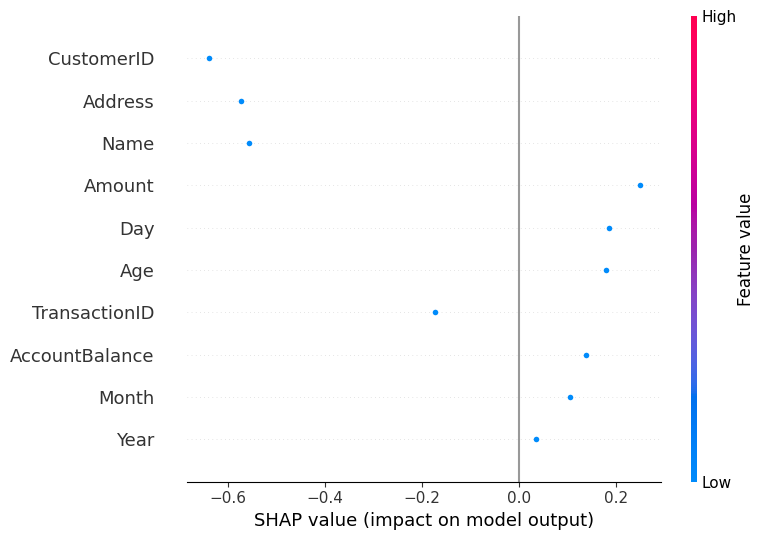

In [115]:
shap_values = explainer.shap_values(encoded_df)
shap.summary_plot(shap_values, encoded_df)